In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


#### Loading the data

##### שימוש בכל הדאטא, כשמחולק רנדומלית לאימון, ולידציה וטסט

Using device: cuda
Train size: 52619
Validation size: 17540
Test size: 17540


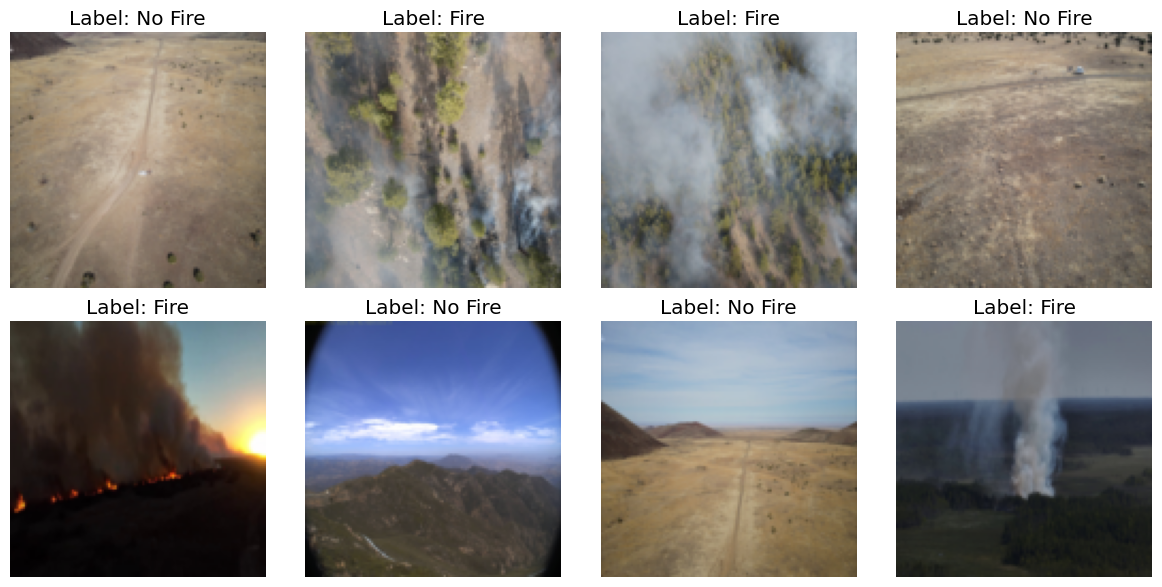

In [3]:
import os
import pandas as pd
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

image_size=120

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

def load_image_label_data(images_dir, labels_excel_path):
    df = pd.read_csv(labels_excel_path)

    # Keep rows where at least one of 'fire' or 'smoke' is not NaN
    df = df.dropna(subset=['fire', 'smoke'], how='all')

    # Remove rows where fire or smoke have invalid values (not 0 or 1), and convert valid ones to int
    df = df[
        ((df['fire'].isin([0, 1])) | df['fire'].isna()) &
        ((df['smoke'].isin([0, 1])) | df['smoke'].isna())
    ]

    # Fill missing values with 0
    df['fire'] = df['fire'].fillna(0).astype(int)
    df['smoke'] = df['smoke'].fillna(0).astype(int)

    # Binary label: 1 = Fire (fire or smoke), 0 = No Fire
    def map_label(row):
        return 1 if row['fire'] == 1 or row['smoke'] == 1 else 0

    df['label'] = df.apply(map_label, axis=1)

    # Generate full image paths
    df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, x))

    # Filter out missing files
    df = df[df['image_path'].apply(os.path.exists)]

    image_paths = df['image_path'].tolist()
    labels = df['label'].tolist()
    return image_paths, labels


# Custom dataset from pre-split lists
class FireSmokeDatasetFromLists(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path  # מוסיפים את הנתיב

# Visualization utility for binary classification
def show_examples(dataset, num_images=8):
    label_names = {
        0: "No Fire",
        1: "Fire"
    }

    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(dataset))):
        img, label, _ = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label_names.get(label, label)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Paths (replace with actual paths)
images_dir = 'Datasets_FromDvir/Datasets/rgb_images'
labels_excel_path = 'Datasets_FromDvir/Datasets/labels.csv'

# Load data
image_paths, labels = load_image_label_data(images_dir, labels_excel_path)

# Stratified split: train (60%), validation (20%), test (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)



# Oversampling using WeightedRandomSampler
from torch.utils.data import WeightedRandomSampler

# Count samples per class (0 = No Fire, 1 = Fire)
class_counts = np.bincount(train_labels)  # e.g. [16343, 36276]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_labels), replacement=True)



# Create datasets
train_dataset = FireSmokeDatasetFromLists(train_paths, train_labels, transform=transform)
val_dataset = FireSmokeDatasetFromLists(val_paths, val_labels, transform=transform)
test_dataset = FireSmokeDatasetFromLists(test_paths, test_labels, transform=transform)

# Create DataLoaders
batch_size = 100
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,  # במקום shuffle
    num_workers=0
)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Print sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Optional: show example images
show_examples(train_dataset)


##### חלוקה של הדאטא לאימון וולידציה, כשFASDD משמש לטסט

Using device: cuda
Train size: 64948
Validation size: 16238
Test size: 6513


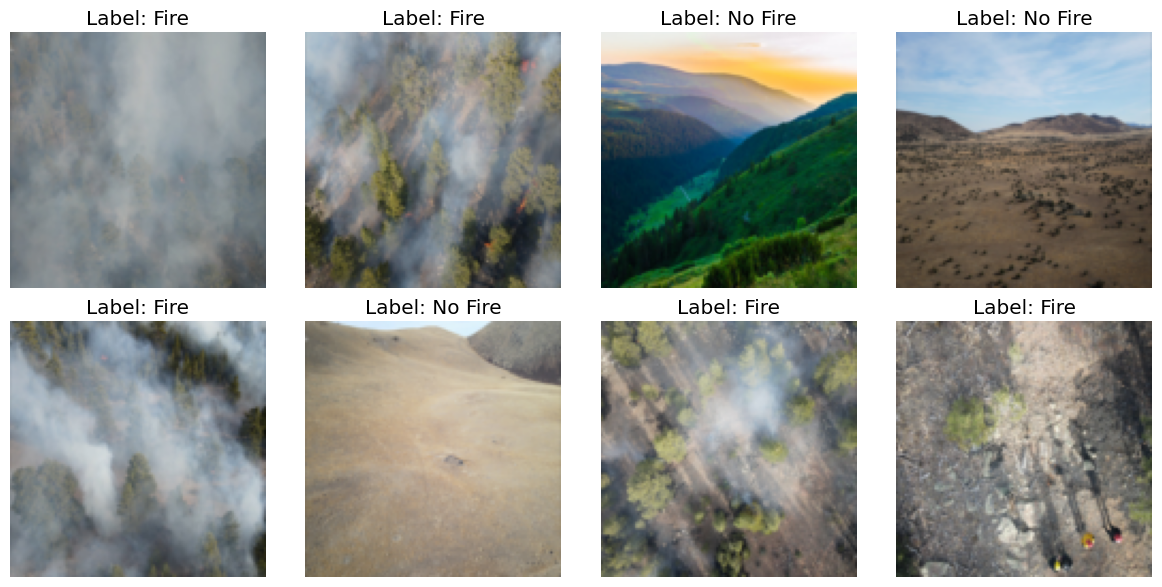


Train set label distribution:
  0 (No Fire): 21401 images
  1 (Fire): 43547 images

Validation set label distribution:
  0 (No Fire): 5351 images
  1 (Fire): 10887 images

Test (FireMan) set label distribution:
  0 (No Fire): 486 images
  1 (Fire): 6027 images


In [3]:
import os
import pandas as pd
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

image_size = 120

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and split data
def load_image_label_data(images_dir, labels_excel_path):
    df = pd.read_csv(labels_excel_path)

    # Keep only rows with valid fire/smoke data
    df = df.dropna(subset=['fire', 'smoke'], how='all')
    df = df[
        ((df['fire'].isin([0, 1])) | df['fire'].isna()) &
        ((df['smoke'].isin([0, 1])) | df['smoke'].isna())
    ]
    df['fire'] = df['fire'].fillna(0).astype(int)
    df['smoke'] = df['smoke'].fillna(0).astype(int)

    # Create binary label: 1 = Fire (fire or smoke), 0 = No Fire
    df['label'] = df.apply(lambda row: 1 if row['fire'] == 1 or row['smoke'] == 1 else 0, axis=1)

    # Create full image paths
    df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, x))
    df = df[df['image_path'].apply(os.path.exists)]

    # Split according to 'dataset' column
    df_trainval = df[df['dataset'] != 'FireMan'].copy()
    df_test = df[df['dataset'] == 'FireMan'].copy()

    return df_trainval, df_test

# Dataset class
class FireSmokeDatasetFromLists(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, image_path

# Visualization utility
def show_examples(dataset, num_images=8):
    label_names = {0: "No Fire", 1: "Fire"}
    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(dataset))):
        img, label, _ = dataset[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img_np)
        plt.title(f"Label: {label_names.get(label, label)}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Paths (update if needed)
images_dir = 'Datasets_FromDvir/Datasets/rgb_images'
labels_excel_path = 'Datasets_FromDvir/Datasets/labels.csv'

# Load data
df_trainval, df_test = load_image_label_data(images_dir, labels_excel_path)

# Split Train/Val from non-FASDD data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    df_trainval['image_path'].tolist(),
    df_trainval['label'].tolist(),
    test_size=0.2,
    stratify=df_trainval['label'].tolist(),
    random_state=42
)

# Use FASDD data as test set
test_paths = df_test['image_path'].tolist()
test_labels = df_test['label'].tolist()

# Oversampling
class_counts = np.bincount(train_labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_labels), replacement=True)

# Create datasets
train_dataset = FireSmokeDatasetFromLists(train_paths, train_labels, transform=transform)
val_dataset = FireSmokeDatasetFromLists(val_paths, val_labels, transform=transform)
test_dataset = FireSmokeDatasetFromLists(test_paths, test_labels, transform=transform)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Optional: Show sample images
show_examples(train_dataset)

from collections import Counter

label_names = {0: "No Fire", 1: "Fire"}

def print_label_distribution(name, labels):
    counts = Counter(labels)
    print(f"\n{name} set label distribution:")
    for label in sorted(counts):
        print(f"  {label} ({label_names[label]}): {counts[label]} images")

# Print label distributions
print_label_distribution("Train", train_labels)
print_label_distribution("Validation", val_labels)
print_label_distribution("Test (FireMan)", test_labels)


## Classification-Guided Encoding
<a id=part2_2></a>

#### Training the model

##### ResNet

cuda
Start training
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
--- EPOCH 1/100 ---
  Train Loss: 0.0743
  Val Loss: 0.0340
  Test Loss: 1.0775
*** Saved checkpoint at epoch 1
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 2
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 3
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 4
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 5
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
--- EPOCH 6/100 ---
  Train Loss: 0.0060
  Val Loss: 0.0079
  Test Loss: 0.6868
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 7
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
*** Saved checkpoint at epoch 8
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
0
10
20
30
40
50
60
70
80
90
100
110
120
0
10
20
30
0
10
0
10
20
30
40
50
60
70
80


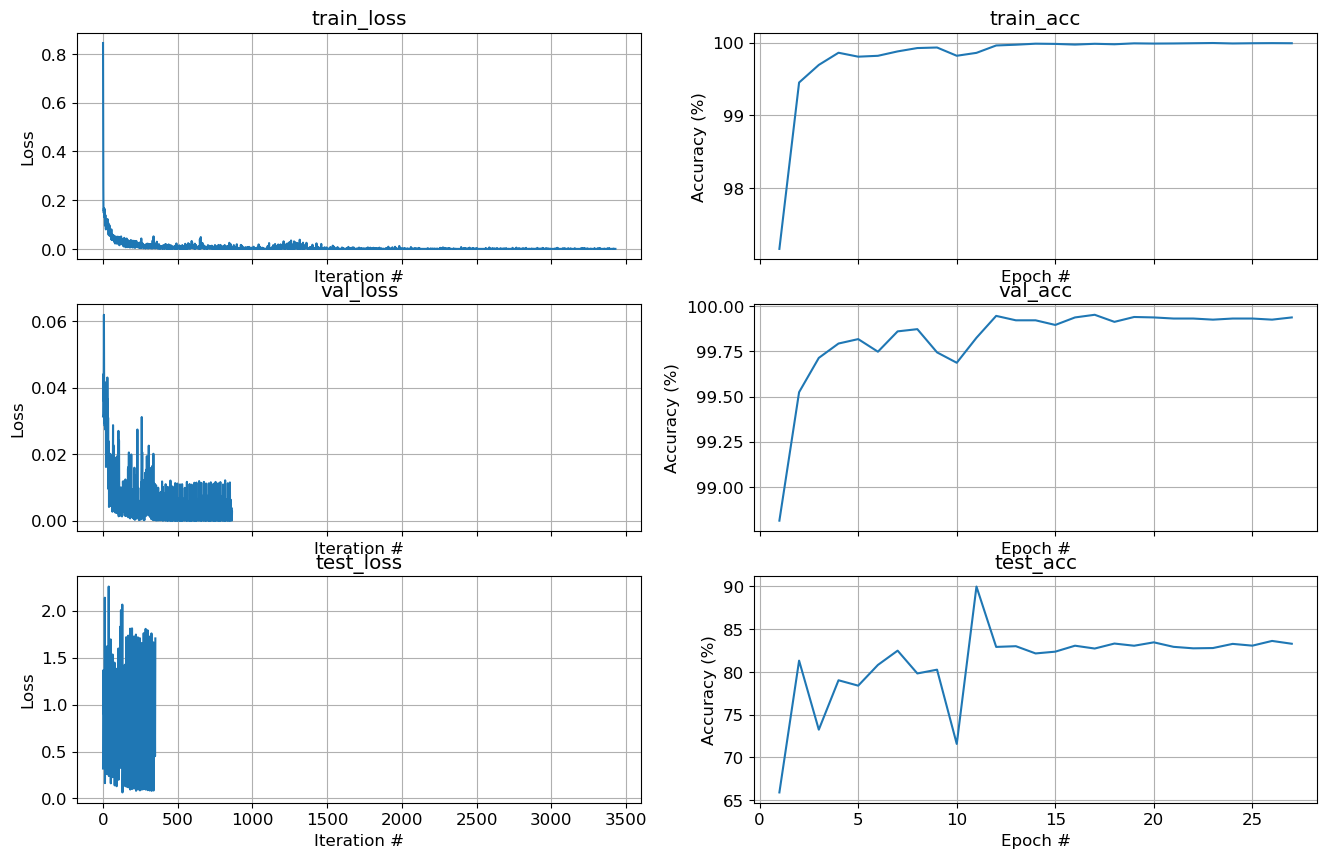

In [4]:
import sys
import os

sys.path.append(os.path.abspath('.'))

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from functions.training import ClassificationGuidedEncoding
from functions.plot import plot_fit

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize Model, Loss, and Optimizer
num_classes = 2

# Use pretrained ResNet18 and adjust the last layer
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001, weight_decay=1e-4)

# Initialize Trainer
trainer = ClassificationGuidedEncoding(resnet, loss_fn, optimizer, device)

# Training the Model
fig_optim = None
fit_res = trainer.fit(
    train_loader, val_loader, test_loader,
    num_epochs=100,
    checkpoints="resnet_fire_classifier",
    early_stopping=10,
    print_every=5,
    max_batches_per_epoch=None
)

fig, axes = plot_fit(fit_res, fig=fig_optim)

print("Training Complete! Model saved at resnet_fire_classifier.pt")

In [5]:
checkpoint = torch.load("resnet_fire_classifier.pt")
best_acc = checkpoint['best_acc']
print(f"Best Accuracy: {best_acc}%")

Best Accuracy: 99.951171875%


In [6]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y, _ in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            print(total)
    return correct / total

acc = evaluate_accuracy(resnet, test_loader, device)
print(f"🔥 Accuracy on FASDD test set: {acc * 100:.2f}%")


512
1024
1536
2048
2560
3072
3584
4096
4608
5120
5632
6144
6513
🔥 Accuracy on FASDD test set: 83.66%


Sample 1: True = Fire, Pred = Fire
Sample 2: True = Fire, Pred = No Fire
Sample 3: True = Fire, Pred = No Fire
Sample 4: True = Fire, Pred = No Fire
Sample 5: True = Fire, Pred = No Fire
Sample 6: True = Fire, Pred = No Fire
Sample 7: True = Fire, Pred = No Fire
Sample 8: True = Fire, Pred = No Fire
Sample 9: True = Fire, Pred = No Fire
Sample 10: True = Fire, Pred = No Fire


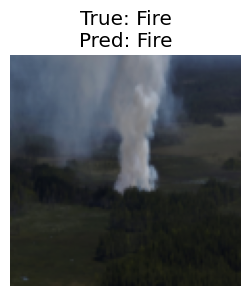

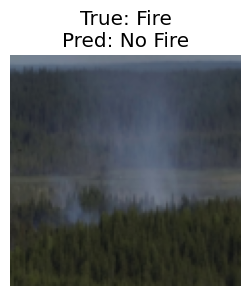

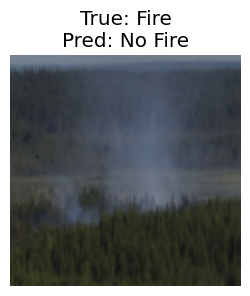

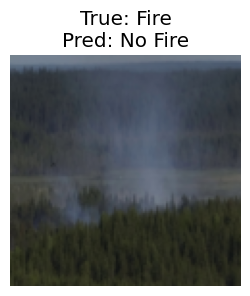

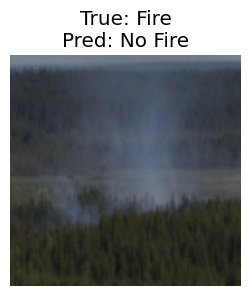

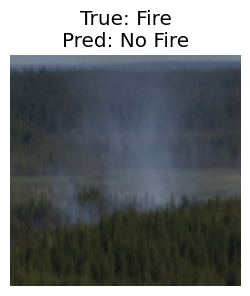

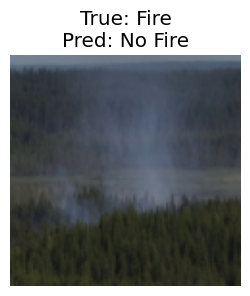

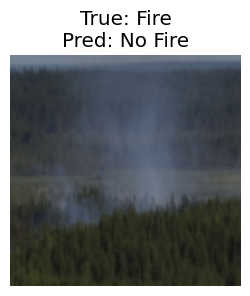

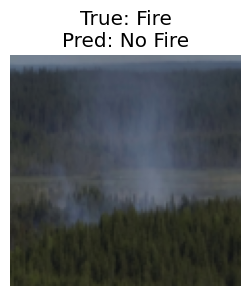

Datasets_FromDvir/Datasets/rgb_images\frame_test_fire_0010.jpg


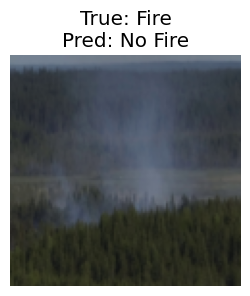

In [7]:
import torch
from torchvision import models

# Load checkpoint
checkpoint = torch.load("resnet_fire_classifier.pt", map_location=device)

# Define model and load state
num_classes = 2
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
resnet.load_state_dict(checkpoint["model_state"])
resnet = resnet.to(device)
resnet.eval()

# Label names
label_names = {
    0: "No Fire",
    1: "Fire",
}

# Show predictions on test set
num_samples_to_show = 10
shown = 0

with torch.no_grad():
    for x, y, paths in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = resnet(x)
        preds = torch.argmax(y_pred, dim=1)

        for i in range(len(x)):
            print(f"Sample {shown+1}: True = {label_names[y[i].item()]}, Pred = {label_names[preds[i].item()]}")
            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break


import matplotlib.pyplot as plt
import numpy as np

label_names = {
    0: "No Fire",
    1: "Fire",
}

# פונקציה לשחזור תמונה מקורית לאחר Normalization
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(tensor.device)
    return tensor * std + mean

# כמה דוגמאות להציג
num_samples_to_show = 10
shown = 0

resnet.eval()
with torch.no_grad():
    for x, y, paths in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = resnet(x)
        preds = torch.argmax(y_pred, dim=1)

        for i in range(x.size(0)):
            if i==9:
                print(paths[i])
            img = unnormalize(x[i]).cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"True: {label_names[y[i].item()]}\nPred: {label_names[preds[i].item()]}")
            plt.show()

            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# לוודא שהמודל ב-eval mode
resnet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = resnet(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# הדפסת מטריצת Confusion (אופציונלי)
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# הדפסת Precision / Recall / F1 לפי קטגוריה
label_names = ["No Fire", "Fire"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names, digits=3))


Confusion Matrix:
[[ 485    1]
 [1099 4928]]

Classification Report:
              precision    recall  f1-score   support

     No Fire      0.306     0.998     0.469       486
        Fire      1.000     0.818     0.900      6027

    accuracy                          0.831      6513
   macro avg      0.653     0.908     0.684      6513
weighted avg      0.948     0.831     0.867      6513



In [9]:
import torch
import torch.nn.functional as F

# לוודא שהמודל במצב הערכה
resnet.eval()

label_names = {
    0: "No Fire",
    1: "Fire",
}

num_samples_to_show = 10
shown = 0

with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)

        # קבלת הפלט הגולמי של המודל (logits)
        outputs = resnet(x)

        # המרה להסתברויות בעזרת softmax
        probs = F.softmax(outputs, dim=1)

        # הסיווג החזוי (המחלקה עם ההסתברות הגבוהה ביותר)
        preds = torch.argmax(probs, dim=1)

        # הדפסה של כל דוגמה עם סיווג וביטחון
        for i in range(len(x)):
            true_label = y[i].item()
            pred_label = preds[i].item()
            confidence = probs[i][pred_label].item() * 100  # המרה לאחוזים

            print(f"Sample {shown+1}: True = {label_names[true_label]}, Pred = {label_names[pred_label]} ({confidence:.1f}% confidence)")
            print(f"Logits: {outputs[i].cpu().numpy()}, Probs: {probs[i].cpu().numpy()}")

            shown += 1
            if shown >= num_samples_to_show:
                break

        if shown >= num_samples_to_show:
            break


Sample 1: True = Fire, Pred = Fire (100.0% confidence)
Logits: [-4.407748  5.466355], Probs: [5.1488347e-05 9.9994850e-01]
Sample 2: True = Fire, Pred = No Fire (97.5% confidence)
Logits: [ 2.1598516 -1.5165114], Probs: [0.9753101  0.02468986]
Sample 3: True = Fire, Pred = No Fire (98.0% confidence)
Logits: [ 2.3124006 -1.5974089], Probs: [0.98034954 0.01965044]
Sample 4: True = Fire, Pred = No Fire (98.9% confidence)
Logits: [ 2.6433377 -1.8271495], Probs: [0.98868775 0.01131231]
Sample 5: True = Fire, Pred = No Fire (98.8% confidence)
Logits: [ 2.6153173 -1.7798944], Probs: [0.98781407 0.01218594]
Sample 6: True = Fire, Pred = No Fire (92.8% confidence)
Logits: [ 1.6310276 -0.9219454], Probs: [0.927773 0.072227]
Sample 7: True = Fire, Pred = No Fire (94.9% confidence)
Logits: [ 1.8050895 -1.1158965], Probs: [0.9488741  0.05112585]
Sample 8: True = Fire, Pred = No Fire (92.2% confidence)
Logits: [ 1.5421326  -0.92620045], Probs: [0.9218918  0.07810818]
Sample 9: True = Fire, Pred = No

In [10]:
import torch
import torch.nn.functional as F

resnet.eval()

label_names = {
    0: "No Fire",
    1: "Fire",
}

num_samples_to_show = 10
shown = 0

with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)

        outputs = resnet(x)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(len(x)):
            true_label = y[i].item()
            pred_label = preds[i].item()
            confidence = probs[i][pred_label].item() * 100

            if pred_label != true_label:
                print(f"❌ MISCLASSIFIED")
                print(f"   True: {label_names[true_label]}, Pred: {label_names[pred_label]} ({confidence:.1f}% confidence)")
                print(f"   Logits: {outputs[i].cpu().numpy()}")
                print(f"   Probabilities: {probs[i].cpu().numpy()}")
                print("-" * 50)

                shown += 1
                if shown >= num_samples_to_show:
                    break

        if shown >= num_samples_to_show:
            break


❌ MISCLASSIFIED
   True: Fire, Pred: No Fire (97.5% confidence)
   Logits: [ 2.1598516 -1.5165114]
   Probabilities: [0.9753101  0.02468986]
--------------------------------------------------
❌ MISCLASSIFIED
   True: Fire, Pred: No Fire (98.0% confidence)
   Logits: [ 2.3124006 -1.5974089]
   Probabilities: [0.98034954 0.01965044]
--------------------------------------------------
❌ MISCLASSIFIED
   True: Fire, Pred: No Fire (98.9% confidence)
   Logits: [ 2.6433377 -1.8271495]
   Probabilities: [0.98868775 0.01131231]
--------------------------------------------------
❌ MISCLASSIFIED
   True: Fire, Pred: No Fire (98.8% confidence)
   Logits: [ 2.6153173 -1.7798944]
   Probabilities: [0.98781407 0.01218594]
--------------------------------------------------
❌ MISCLASSIFIED
   True: Fire, Pred: No Fire (92.8% confidence)
   Logits: [ 1.6310276 -0.9219454]
   Probabilities: [0.927773 0.072227]
--------------------------------------------------
❌ MISCLASSIFIED
   True: Fire, Pred: No Fire

##### Ours

In [5]:
import torch.nn as nn
import torch.optim as optim

from functions.autoencoder import Encoder2
from functions.training import ClassificationGuidedEncoding
from functions.Classifier import AutoencoderClassifier, Classifier
from functions.plot import plot_fit

# Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize Model, Loss, and Optimizer
latent_dim = 8
# autoencoder = Encoder2(latent_dim=latent_dim).to(device)
autoencoder = Encoder2(input_size=(3, image_size, image_size), latent_dim=latent_dim).to(device)
classifier_org = Classifier(input_dim=latent_dim, num_classes=2).to(device)
classifier = AutoencoderClassifier(autoencoder, classifier_org).to(device)

loss_fn = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-4)

# Initialize Trainer
trainer = ClassificationGuidedEncoding(classifier, loss_fn, optimizer, device)


cuda


Start training
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
--- EPOCH 1/50 ---
  Train Loss: 0.6794
  Val Loss: 0.6532
  Test Loss: 0.6549
*** Saved checkpoint at epoch 1
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
*** Saved checkpoint at epoch 2
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
*** Saved checkpoint at epoch 3
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
*** Saved checkpoint at epoch 5
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
--- EPOCH 6/50 ---
  Train Loss: 0.4527
  Val Loss: 0.3487
  Test Loss: 0.3516
*** Saved checkpoint at epoch 6
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
*** Saved checkpoint at epoch 7
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
*** Saved checkpoint at epoch 10
0
10
20
30
40
50
0
10
20
30
40
50
0
10
20
30
40
50
--- EPOCH 11/50 ---
  Train Loss: 0.3682


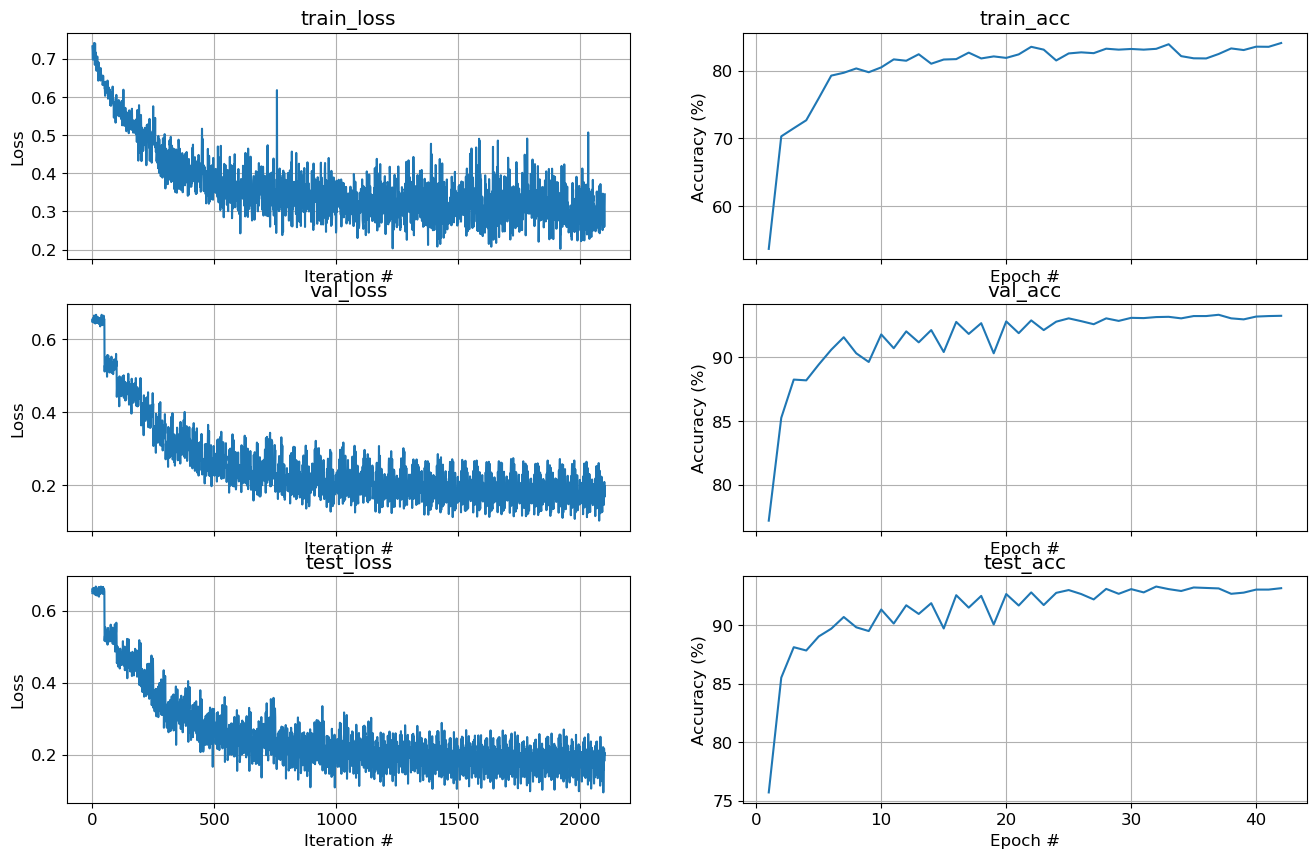

In [6]:
# Training the Model
fig_optim = None
fit_res = trainer.fit(train_loader, val_loader, test_loader, num_epochs=50, checkpoints="encoderclassifier",
                      early_stopping=5, print_every=5, max_batches_per_epoch=50)
fig, axes = plot_fit(fit_res, fig=fig_optim)

print("Training Complete! Model saved at encoderclassifier.pt")

In [8]:
checkpoint = torch.load("encoderclassifier.pt")
best_acc = checkpoint['best_acc']
print(f"Best Accuracy: {best_acc}%")

FileNotFoundError: [Errno 2] No such file or directory: 'encoderclassifier.pt'

In [8]:
from collections import Counter

label_names = {
    0: "No Fire",
    1: "Fire",
}

counts = Counter(labels)

print("Number of images per label:")
for label in sorted(counts.keys()):
    print(f"  {label} ({label_names[label]}): {counts[label]} images")


def print_label_distribution(name, labels):
    counts = Counter(labels)
    print(f"\n {name} set label distribution:")
    for label in sorted(counts.keys()):
        print(f"  {label} ({label_names[label]}): {counts[label]} images")

print_label_distribution("Train", train_labels)
print_label_distribution("Validation", val_labels)
print_label_distribution("Test", test_labels)


Number of images per label:
  0 (No Fire): 27238 images
  1 (Fire): 60461 images

 Train set label distribution:
  0 (No Fire): 16343 images
  1 (Fire): 36276 images

 Validation set label distribution:
  0 (No Fire): 5447 images
  1 (Fire): 12093 images

 Test set label distribution:
  0 (No Fire): 5448 images
  1 (Fire): 12092 images


In [8]:
from collections import Counter

actual_sampled_labels = []

for i, (x, y, _) in enumerate(train_loader):
    actual_sampled_labels.extend(y.tolist())
    if i >= 10:  # בדוגמה: נבדוק רק את 10 ה-batches הראשונים
        break

sampled_counts = Counter(actual_sampled_labels)
print("\nSampled batch label distribution (first 10 batches):")
for label in sorted(sampled_counts.keys()):
    print(f"  {label} ({label_names[label]}): {sampled_counts[label]} samples")



Sampled batch label distribution (first 10 batches):
  0 (No Fire): 683 samples
  1 (Fire): 725 samples


In [11]:
checkpoint = torch.load("encoderclassifier.pt", map_location=device)

from functions.autoencoder import Encoder2
from functions.Classifier import Classifier, AutoencoderClassifier

latent_dim = 8  # ודאי שזה תואם למה שהשתמשת בו באימון
input_size = (3, image_size, image_size)

encoder = Encoder2(input_size=input_size, latent_dim=latent_dim)
classifier_head = Classifier(input_dim=latent_dim, num_classes=2)
model = AutoencoderClassifier(encoder, classifier_head)

model.load_state_dict(checkpoint["model_state"])
model.to(device)
model.eval()

label_names = {
    0: "No Fire",
    1: "Fire",
}

num_samples_to_show = 10
shown = 0

with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)

        for i in range(len(x)):
            print(f"Sample {shown+1}: True = {label_names[y[i].item()]}, Pred = {label_names[preds[i].item()]}")
            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break


RuntimeError: Error(s) in loading state_dict for AutoencoderClassifier:
	Missing key(s) in state_dict: "autoencoder.IN.0.weight", "autoencoder.IN.0.bias", "autoencoder.IN.1.weight", "autoencoder.IN.1.bias", "autoencoder.IN.1.running_mean", "autoencoder.IN.1.running_var", "autoencoder.residual_conv.weight", "autoencoder.residual_conv.bias", "autoencoder.block.0.depthwise.weight", "autoencoder.block.0.pointwise.weight", "autoencoder.block.1.weight", "autoencoder.block.1.bias", "autoencoder.block.1.running_mean", "autoencoder.block.1.running_var", "autoencoder.block.3.depthwise.weight", "autoencoder.block.3.pointwise.weight", "autoencoder.block.4.weight", "autoencoder.block.4.bias", "autoencoder.block.4.running_mean", "autoencoder.block.4.running_var", "autoencoder.block2.0.depthwise.weight", "autoencoder.block2.0.pointwise.weight", "autoencoder.block2.1.weight", "autoencoder.block2.1.bias", "autoencoder.block2.1.running_mean", "autoencoder.block2.1.running_var", "autoencoder.projector.weight", "autoencoder.projector.bias", "classifier.fc.0.weight", "classifier.fc.0.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

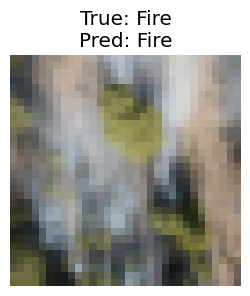

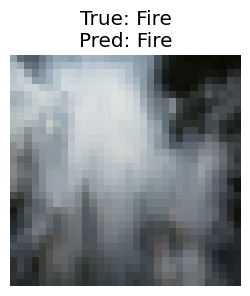

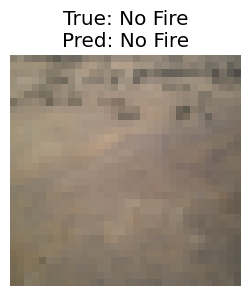

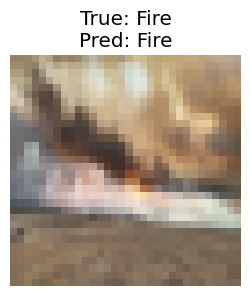

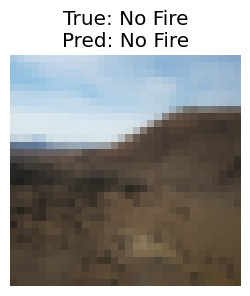

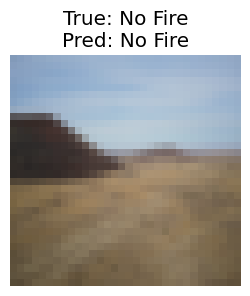

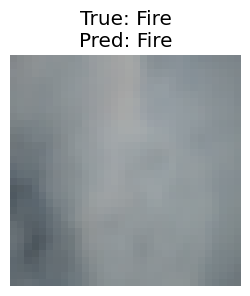

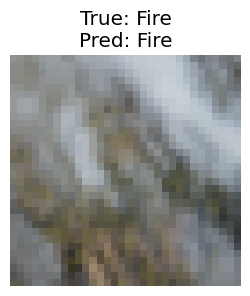

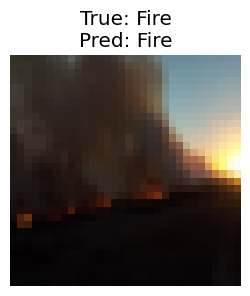

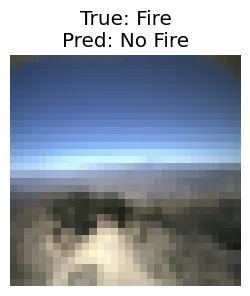

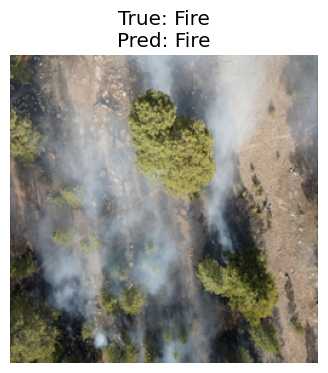

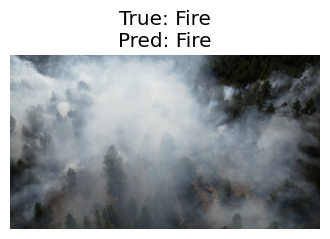

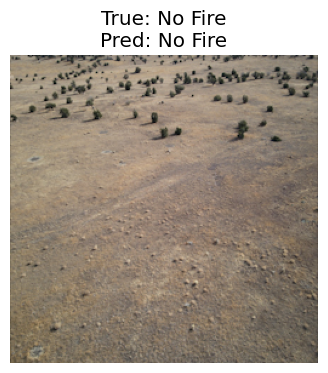

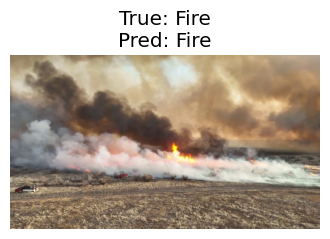

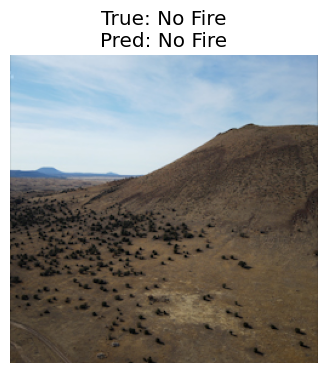

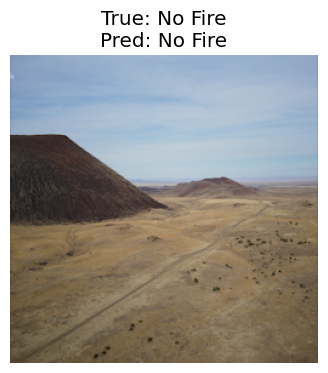

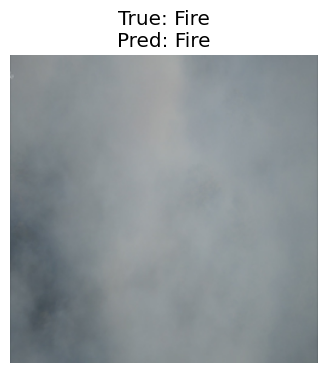

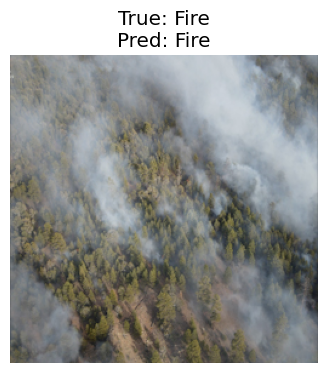

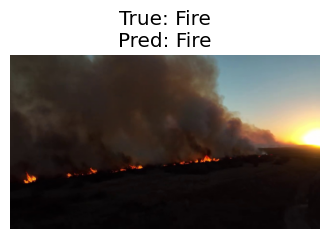

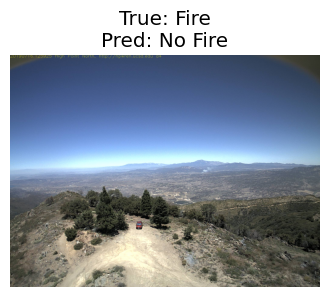

In [18]:
import matplotlib.pyplot as plt
import numpy as np

label_names = {
    0: "No Fire",
    1: "Fire",
}

# פונקציה לשחזור תמונה מקורית לאחר Normalization
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(tensor.device)
    return tensor * std + mean

# כמה דוגמאות להציג
num_samples_to_show = 10
shown = 0

model.eval()
with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)

        for i in range(x.size(0)):
            img = unnormalize(x[i]).cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            plt.figure(figsize=(3,3))
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"True: {label_names[y[i].item()]}\nPred: {label_names[preds[i].item()]}")
            plt.show()

            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break

shown = 0
with torch.no_grad():
    for batch in test_loader:
        x, y, paths = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)

        for i in range(x.size(0)):
            # פתח את התמונה המקורית מהדיסק
            orig_img = Image.open(paths[i]).convert('RGB')

            plt.figure(figsize=(4,4))
            plt.imshow(orig_img)
            plt.axis("off")
            plt.title(f"True: {label_names[y[i].item()]}\nPred: {label_names[preds[i].item()]}")
            plt.show()

            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# לוודא שהמודל ב-eval mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# הדפסת מטריצת Confusion (אופציונלי)
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# הדפסת Precision / Recall / F1 לפי קטגוריה
label_names = ["No Fire", "Fire"]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names, digits=3))


Confusion Matrix:
[[ 4802   646]
 [  949 11143]]

Classification Report:
              precision    recall  f1-score   support

     No Fire      0.835     0.881     0.858      5448
        Fire      0.945     0.922     0.933     12092

    accuracy                          0.909     17540
   macro avg      0.890     0.901     0.895     17540
weighted avg      0.911     0.909     0.910     17540

